# IRT Solver - Unidieme Latent Variable Data Generation
We first assume that each item measures a single sub-scale, and we report population scores on the same sub-scale. Thus, the problem can be solved separately for every sub-scale.

To test our non-parametric IRT model, we generate items with a parameteric form and sample student abilities from the standard prior distributions assumed in IRT literature. We then use our solver (simulated annealing and IRF refinement out loop, with MCMC estimation of $\theta$ within each step).

In [38]:
# Simulate MCMC model data: pick the true parameter variables from the model's prior distribution.
#import cluster.cntree.cntree as cntree
import collections
import logging
import matplotlib.pyplot as plt
import nirt.irf
import nirt.mcmc
import nirt.simulate.simulate_data
import nirt.solver
import numpy as np
import numpy.matlib
from numpy.linalg import norm, svd

%load_ext autoreload
%autoreload 2

level = logging.INFO
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(level=level, format="%(levelname)-8s %(message)s", datefmt="%a, %d %b %Y %H:%M:%S")

# Deterministic results.
numpy.random.seed(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
# Number of persons.
P = 1000
# Number of items.
I = 20
# Number of latent ability dimensions (sub-scales).
C = 1
# Fixed item asymptote (pi) as theta -> -\infty = probability of guessing.
asym = 0 # 0.25
# Constant a for all items.
discrimination = 1

In [40]:
X, theta, b, c = nirt.simulate.simulate_data.generate_simulated_data(P, I, C, asym=asym, discrimination=discrimination)

(1000, 1)


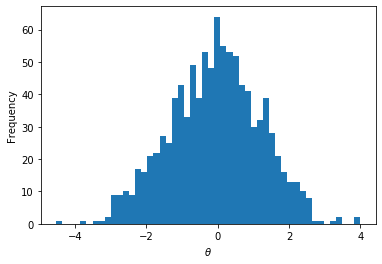

In [41]:
# Verify that student latent abilities are normally distributed. theta_c ~ N(0, invgamma(a_c,b_c))
print(theta.shape)
plt.hist(theta, 50)
plt.xlabel(r'$\theta$')
plt.ylabel('Frequency')
plt.show()

# Initial Guess for $\theta$
Initial guess for $\theta_p^c$: the number of standard deviations person's c's success fraction is away from the mean success fraction of persons in items measuring sub-scale $c$.

When we add more persons to the simulation at each refinement step, we use the MLE ($T=0$) as the initial guess for the added persons's $\theta_p$'s.

# Building IRFs from $\theta$
The IRF of item $i$ is a 1D function of $\theta$ in this case. Use a histogram of the currently "active" persons (those being estimated) to build the IRF.

In [42]:
solver = nirt.solver.Solver(X, c, sample_size=20, num_iterations=5, num_sweeps=5)
theta = solver.initial_guess()

In [97]:
# For each dimension, bin persons by theta values into n bins so that there are at most sample_size in each bin.
n = 10
bins = nirt.irf.sample_bins(theta[:, 0], n, solver._sample_size)
print("Sampled persons into bins of minimum size {}; sample size {}".format(
    solver._sample_size, sum(len(bin) for bin in bins)))
# Build IRFs from theta values. Assuming the same resolution for all item IRFs, so this is an I x n array.
irf = nirt.irf.ItemResponseFunction.merge([nirt.irf.histogram(X[:, i], bins) for i in range(I)])

Sampled persons into bins of minimum size 20; sample size 80


[0.00131635 0.00964543 0.0671335  0.3471526  0.79712493 0.9667029
 0.99536014 0.99936953 0.99991463 0.99998845]
[0.   0.   0.   0.25 0.65 0.95 1.   0.   0.   0.  ]
|parametric-all samples| MSE 0.06
|parametric - sampled|   MSE 0.06
|all samples - sampled|  MSE 0.04


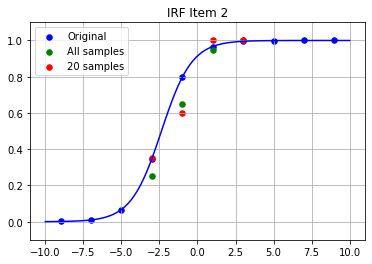

In [127]:
i = 2 # Item number

sampled_bins = nirt.irf.sample_bins(theta[:, c[i]], n, solver._sample_size)
sampled_irf = nirt.irf.histogram(X[:,i], sampled_bins)

ax = plt.gca()
def model_irf(t): return nirt.simulate.simulate_data.three_pl_model(t, discrimination, b[i], asym)
nirt.simulate.simulate_data.plot_model_irf(ax, model_irf, n, color="blue", label="Original")
nirt.simulate.simulate_data.plot_discrete_irf(ax, irf[i], n, color="green", label="All samples")
nirt.simulate.simulate_data.plot_discrete_irf(ax, sampled_irf,  n, color="red", label="{} samples".format(solver._sample_size))
plt.title("IRF Item {}".format(i))
ax.grid(True)
_ = ax.legend()

bin_centers = nirt.irf.bin_centers(n)
exact_irf = np.array([model_irf(t) for t in bin_centers])
print(exact_irf)
print(irf.probability[i])
def error(exact_irf, irf):
    has_data = irf.count > 0
    return exact_irf[has_data] - irf.probability[has_data]
e = error(exact_irf, irf[i])
print("|parametric-all samples| MSE {:.2f}".format(np.linalg.norm(e)/n**0.5))
e = error(exact_irf, sampled_irf)
print("|parametric - sampled|   MSE {:.2f}".format(np.linalg.norm(e)/n**0.5))

d = (sampled_irf.count > 0) & (irf[i].probability > 0)
print("|all samples - sampled|  MSE {:.2f}".format(np.linalg.norm(sampled_irf.probability[d] - irf[i].probability[d])/n**0.5))

$P_i(\theta)$ is monotonically increasing. The discrete approximation to the original synthetic (parametric) form is excellent. 20 persons per bin gives a reasonable approximation.

# Initial Guess for incoming $\theta$ (upon refinement)
When we add more persons to the simulation at each refinement step, we use the MLE ($T=0$) as the initial guess for the added persons's $\theta_p$'s.

In [126]:
likelihood = nirt.likelihood.Likelihood(X, c, irf)

p 0 MLE estimator: 0.0


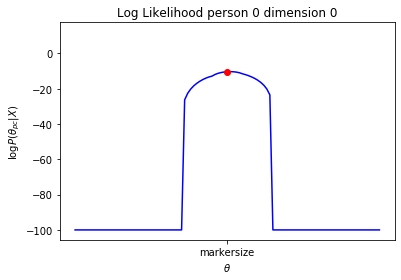

p 1 MLE estimator: 3.30123566177973


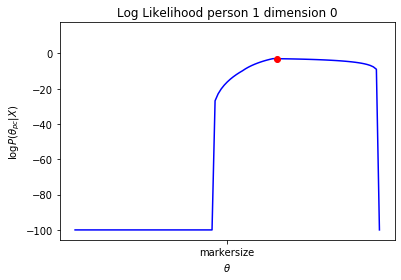

p 2 MLE estimator: -2.4561724771840048


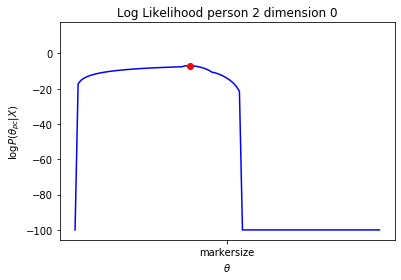

In [84]:
for p in range(3):
    # Check whether the likelihood of a person's theta is concave (has a unique maximum).
    likelihood.plot_person_log_likelihood(p, 0)
    # See that we can find this minimum with a root finder.
    t = likelihood.parameter_mle(p, 0)
    print("p {} MLE estimator: {}".format(p, t))
    plt.plot(t, likelihood.person_log_likelihood(p, 0, t), 'ro', 'markersize', 12)
    plt.show()

# Improving $\theta$ estimates with MCMC

In [130]:
theta = solver.initial_guess()
n = 10
T = 1
t = solver.solve_at_resolution(n, T, theta)

INFO     Sampled persons into bins of minimum size 20; sample size 80
INFO     Building IRF
INFO     log-likelikhood -8577.79
INFO     MCMC sweep  0 log-likelikhood -8614.2720 accepted 88.30%
INFO     MCMC sweep  1 log-likelikhood -8631.2586 accepted 87.90%
INFO     MCMC sweep  2 log-likelikhood -8658.7357 accepted 87.57%
INFO     MCMC sweep  3 log-likelikhood -8686.4474 accepted 88.05%
INFO     MCMC sweep  4 log-likelikhood -8621.6448 accepted 88.20%
INFO     Building IRF
INFO     log-likelikhood -8621.64
INFO     MCMC sweep  0 log-likelikhood -8650.7560 accepted 86.80%
INFO     MCMC sweep  1 log-likelikhood -8665.7994 accepted 85.90%
INFO     MCMC sweep  2 log-likelikhood -8604.8995 accepted 85.97%
INFO     MCMC sweep  3 log-likelikhood -8613.6848 accepted 86.25%
INFO     MCMC sweep  4 log-likelikhood -8638.2487 accepted 86.62%
INFO     Building IRF
INFO     log-likelikhood -8638.25
INFO     MCMC sweep  0 log-likelikhood -8553.3508 accepted 87.10%
INFO     MCMC sweep  1 log-likelikho